In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as image
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.append('../')
import pyEMsoft
from pyEMsoftTools import Tools
from pyEMsoftTools import ExtractData
import numpy as np
import h5py as h5

In [16]:
# path=input('Absolute path to the master pattern file:')
path='/Users/chaoyizhu/Downloads/Ni-master-20kV.h5'
# read the hdf5 master pattern file 
hdfData = h5.File(path, 'r')
# master_info: Bethe paramters, Energy Bins, Z2percent, lastEnergy, 
# master_pattern: LPNH, LPSH, SPNH, SPSH
master_info, master_pattern=ExtractData(hdfData).ebsd_master()
# extract master patterns
Master_SPNH=master_pattern['SPNH']
Master_SPSH=master_pattern['SPSH']
#Master_LPNH=master_pattern['LPNH']
#Master_LPSH=master_pattern['LPSH']

# Intead of using the Master_LPNH and Master_LPSH from master_pattern
# let's look at how we can use Fortran routines to obtain these Lamber master patterns

In [26]:
# MPfile=input('Master pattern file (path relative to EMdatapathname):')
MPfile = 'Ni-master-20kV.h5'
# hdferror (inout int), hdferror=0, no error; hdferror=1 means error returned
hdferr = np.asarray([0], dtype=int, order='F')
# open the hdf5 interface first
pyEMsoft.hdfsupport.h5open_emsoft(hdferr)
# master pattern namelist types
mpnl = pyEMsoft.namelisttypedefs.EBSDMasterNameListType()
# Monte Carlo namelist types
mcnl = pyEMsoft.namelisttypedefs.MCCLNameListType()
# master pattern data types
EBSDMPdata = pyEMsoft.typedefs.EBSDMPdataType()
# Monte Carlo data types
EBSDMCdata = pyEMsoft.typedefs.EBSDMCdataType()
# get the Monte Carlo data (accum_e)
pyEMsoft.ebsdmod.readebsdmontecarlofile(MPfile, mcnl, EBSDMCdata, getaccume=True)
# get the mLPNH (rank 3) and mLPSH (rank 3)
pyEMsoft.ebsdmod.readebsdmasterpatternfile(MPfile, mpnl, EBSDMPdata, getmlpnh=True, getmlpsh=True)
# close the hdf5 interface
pyEMsoft.hdfsupport.h5close_emsoft(hdferr)
# accum_e for each energy bin
accum_e = np.sum(EBSDMCdata.accum_e, axis=(1,2))
# weighted accum_e
accum_e = accum_e / np.sum(accum_e)
# weighted average of the master Lambert projection patterns
Master_LPNH = np.average(EBSDMPdata.mlpnh, axis=2, weights=accum_e)
Master_LPSH = np.average(EBSDMPdata.mlpsh, axis=2, weights=accum_e)

Text(0.5, 1.02, 'Stereographic Projection Southern Hemisphere')

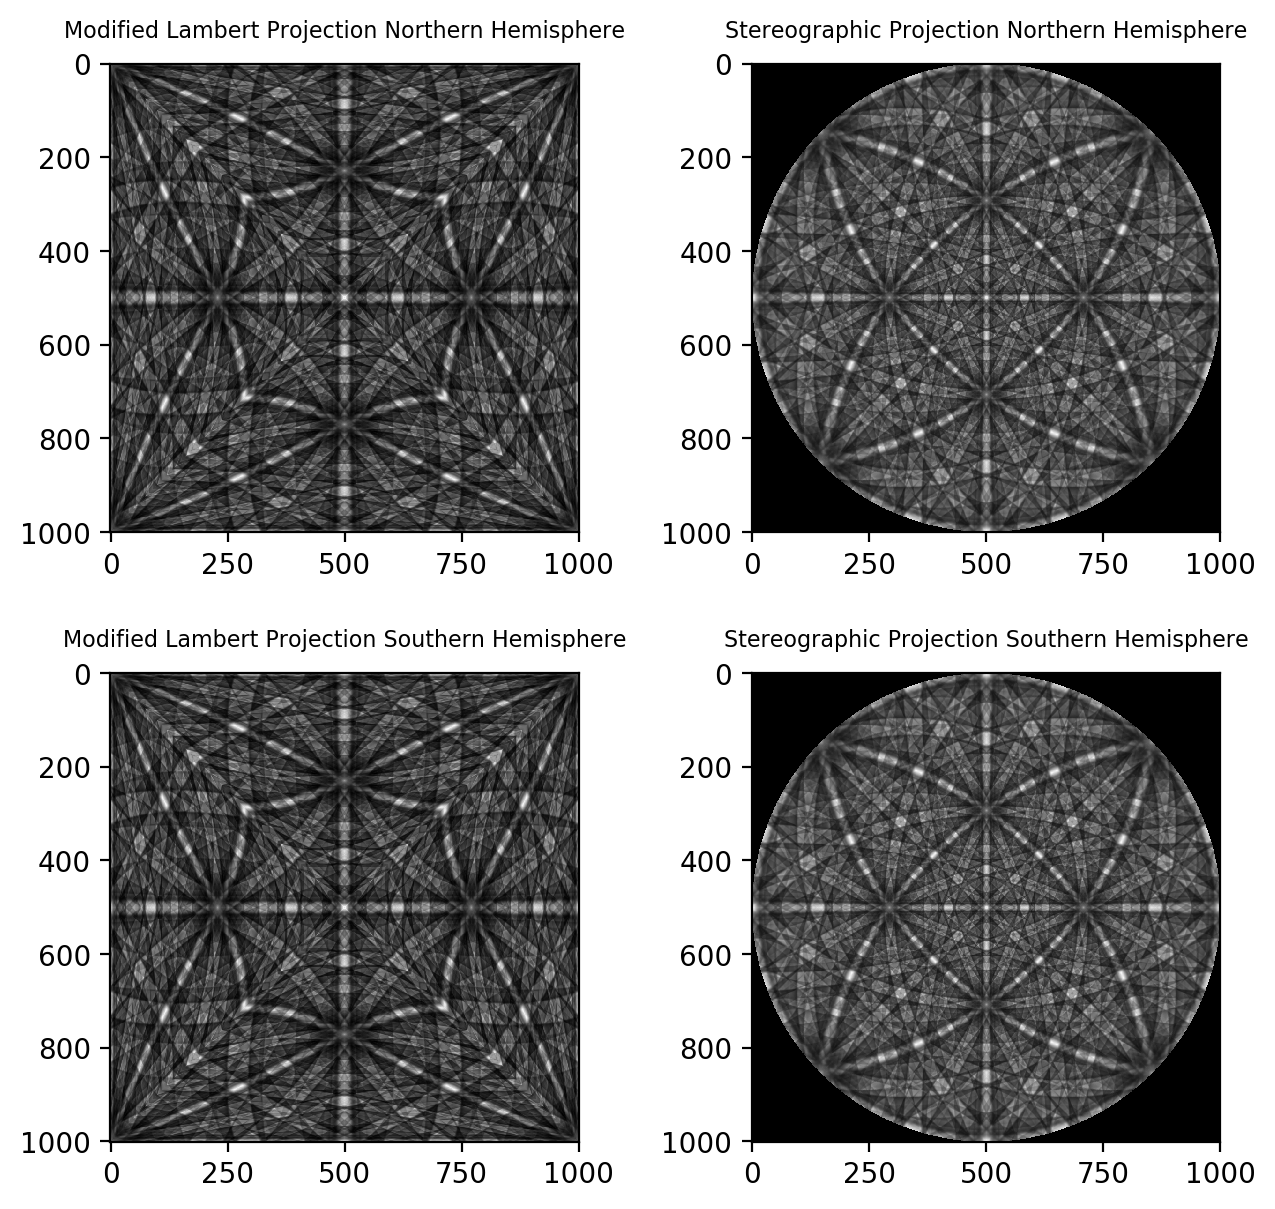

In [25]:
# plot the four master patterns
%matplotlib inline
plt.figure(figsize=(7,7), dpi=200)
plt.subplots_adjust(wspace=0.2,hspace=0.3,top=0.85,left=0.08,right=0.92,bottom=0.08) 
ax = plt.subplot(221)
colormap=cm.gray
plt.imshow(Master_LPNH, cmap=colormap) 
ax.set_aspect('equal')
ax.set_title('Modified Lambert Projection Northern Hemisphere',fontsize=8,y=1.02)

ax = plt.subplot(222)
plt.imshow(Master_SPNH, cmap=colormap) 
ax.set_aspect('equal')
ax.set_title('Stereographic Projection Northern Hemisphere',fontsize=8,y=1.02)

ax = plt.subplot(223)
plt.imshow(Master_LPSH, cmap=colormap) 
ax.set_aspect('equal')
colormap=cm.gray
ax.set_title('Modified Lambert Projection Southern Hemisphere',fontsize=8,y=1.02)

ax = plt.subplot(224)
plt.imshow(Master_SPSH, cmap=colormap)
ax.set_aspect('equal')
ax.set_title('Stereographic Projection Southern Hemisphere',fontsize=8,y=1.02)


In [5]:
# resolutions of master pattern in x = y (odd number)
size=Master_LPNH.shape[0]
# r used to fix the origin
r=(size-1)/2
# prescale the pattern for 2D lambert square coordinates to 3D spherical coordinates transformation (lambert.f90)
# for stereographic to sphere transformation (f=1/size)
f=2/size
# define an empty numpy array for the output
xyz=np.zeros([3,size,size])
# calculate the 3D coordinates with the lambertsquaretosphere routine
for i in range(size):
    for j in range(size):
        xy=np.array([(i-r)*f, (j-r)*f])       
        xyz[:,i,j]=pyEMsoft.lambert.lambertsquaretosphere(xy,0)


<IPython.core.display.Javascript object>


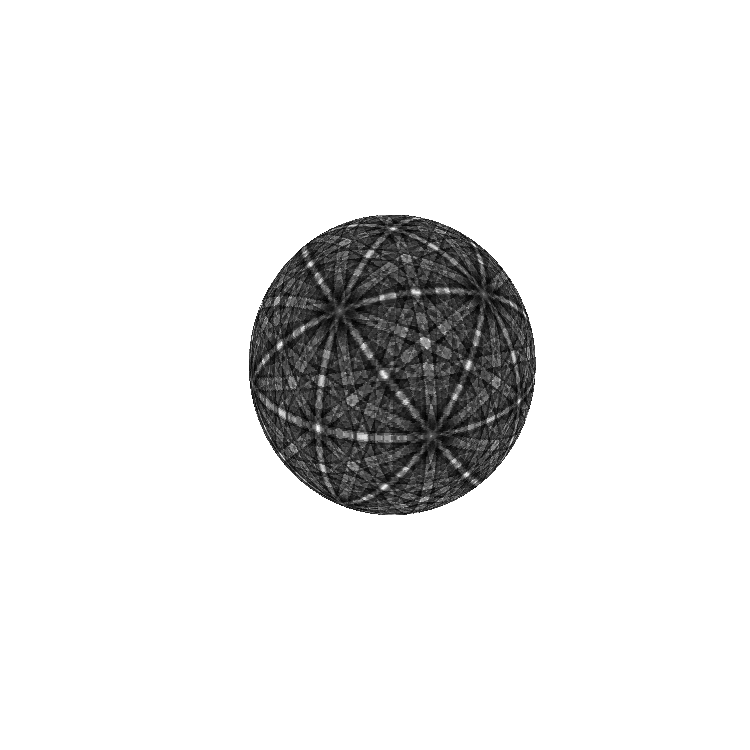

In [7]:
# plot the 3D Kikuchi sphere
%matplotlib notebook
fig = plt.figure(figsize=(5,5), dpi=150)
ax = fig.add_subplot(111, projection='3d')
norm = mpl.colors.Normalize(vmin=np.min(Master_LPNH), vmax=np.max(Master_LPNH), clip = False)
x=np.reshape(xyz[0,:,:],(size,size))
y=np.reshape(xyz[1,:,:],(size,size))
z=np.reshape(xyz[2,:,:],(size,size))
ax.plot_surface(x,y,z,rstride=3,cstride=3,linewidth=0, antialiased=False, facecolors=plt.cm.gray(norm(Master_LPNH)),shade=False)
ax.plot_surface(x,y,-z,rstride=3,cstride=3,linewidth=0, antialiased=False, facecolors=plt.cm.gray(norm(Master_LPSH)),shade=False)
ax.set_axis_off()
plt.show()